## Machine Learning Class Project
Chris Reimann

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings
import tensorflow.keras
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
! pip install nltk

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

# Initialize the stopwords
stoplist = stopwords.words('english')

import nltk
import re
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chrisreimann/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chrisreimann/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [117]:
%cd /Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project

/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project


In [6]:
import os
for dirname, _, filenames in os.walk('/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project/MLProject.ipynb
/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project/.DS_Store
/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project/Project Ideas
/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project/glove.6B.100d.txt
/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project/Meeting Notes
/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project/Teja Code/.DS_Store
/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project/Teja Code/check.py
/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project/Teja Code/adversarial_training.py
/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project/Teja Code/train.py
/Users/chrisreimann/Desktop/U_Chicago/MSCA_31009_Machine_Learning/Course_Project/Teja Code/inference.py
/Us

In [7]:
tweet = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [8]:
tweet.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [9]:
test.count()

id          3263
keyword     3237
location    2158
text        3263
dtype: int64

/Users/chrisreimann/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

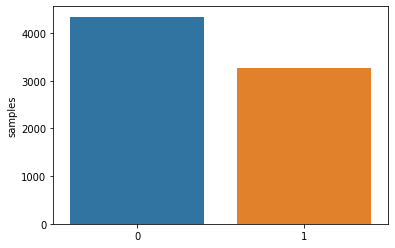

In [10]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

## Data Cleaning - GLOVE

In [11]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

In [12]:
def remove_URL(text): # Remove Urls
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

In [13]:
def remove_html(text): # Remove html tags
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

In [14]:
def remove_emoji(text): # Remove Emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [15]:
def remove_punct(text): # Remove punctuations
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text']=df['text'].apply(lambda x : remove_punct(x))


In [16]:
!pip install pyspellchecker # Spelling Correction

     |████████████████████████████████| 1.9 MB 2.5 MB/s eta 0:00:01


In [17]:
from spellchecker import SpellChecker
spell = SpellChecker()
counter=0
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
      if word in misspelled_words:
          corrected_text.append(spell.correction(word))
      else:
          corrected_text.append(word)
    return " ".join(corrected_text)
    

#df['text']=df['text'].apply(lambda x : correct_spellings(x))

## GloVe for Vectorization

In [18]:
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [19]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 7660.52it/s]


In [21]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [23]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [24]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 291306.71it/s]


## Resplit data for validation

In [25]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [26]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


# MODELS

In [27]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
 
# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 1)
	y = y.reshape(1, n_timesteps, 1)
	return X, y

In [108]:
# define LSTM
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Bidirectional,TimeDistributed
from keras.initializers import Constant

model = Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.35))
model.add(Bidirectional(LSTM(64,dropout=0.35, recurrent_dropout=0.35)))
model.add(Dense(1, activation='sigmoid'))

In [109]:
# Compile model - Binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [110]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 2,118,909
Trainable params: 84,609
Non-trainable params: 2,034,300
_________________________________________________________________


In [111]:
# train LSTM
history2=model.fit(X_train,y_train, epochs=15, batch_size=4, validation_data=(X_test,y_test),verbose=1)

Epoch 1/15
1618/1618 [==============================] - 89s 55ms/step - loss: 0.5093 - accuracy: 0.7583 - val_loss: 0.4963 - val_accuracy: 0.7618
Epoch 2/15
1618/1618 [==============================] - 89s 55ms/step - loss: 0.4819 - accuracy: 0.7810 - val_loss: 0.4506 - val_accuracy: 0.7925
Epoch 3/15
1618/1618 [==============================] - 82s 51ms/step - loss: 0.4579 - accuracy: 0.7963 - val_loss: 0.4781 - val_accuracy: 0.7785
Epoch 4/15
1618/1618 [==============================] - 88s 54ms/step - loss: 0.4591 - accuracy: 0.7914 - val_loss: 0.4530 - val_accuracy: 0.7977
Epoch 5/15
1618/1618 [==============================] - 86s 53ms/step - loss: 0.4431 - accuracy: 0.8017 - val_loss: 0.4637 - val_accuracy: 0.8021
Epoch 6/15
1618/1618 [==============================] - 85s 52ms/step - loss: 0.4284 - accuracy: 0.8105 - val_loss: 0.4671 - val_accuracy: 0.7881
Epoch 7/15
1618/1618 [==============================] - 86s 53ms/step - loss: 0.4337 - accuracy: 0.8079 - val_loss: 0.4571 -

In [112]:
model.save('BiLSTM_project_model.h5')
print("Saved model")

Saved model


In [113]:
model.history.history['val_accuracy']

[0.7618213891983032,
 0.792469322681427,
 0.778458833694458,
 0.7977232933044434,
 0.8021015524864197,
 0.7880910634994507,
 0.7994745969772339,
 0.7985989451408386,
 0.8056042194366455,
 0.8064798712730408,
 0.8064798712730408,
 0.7950963377952576,
 0.8047285676002502,
 0.8029772043228149,
 0.8056042194366455]

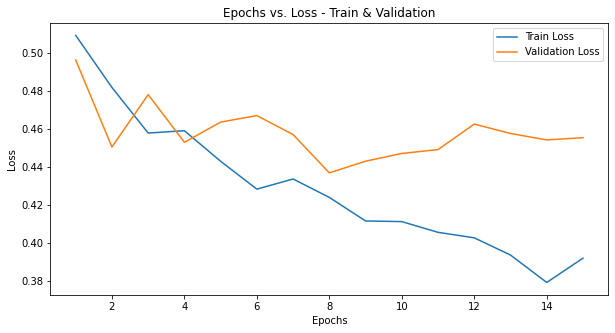

In [114]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1,16)),list(model.history.history['loss']),label='Train Loss')
plt.plot(list(range(1,16)),list(model.history.history['val_loss']), label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Epochs vs. Loss - Train & Validation')
plt.legend(loc='upper right')

plt.show()

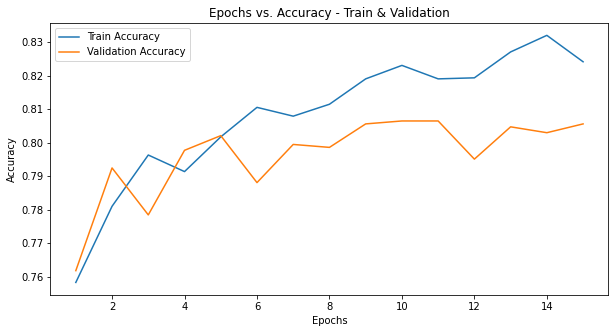

In [115]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1,16)),list(model.history.history['accuracy']),label='Train Accuracy')
plt.plot(list(range(1,16)),list(model.history.history['val_accuracy']), label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Epochs vs. Accuracy - Train & Validation')
plt.legend(loc='upper left')

plt.show()

### Submission

In [120]:
sample_sub=pd.read_csv('sample_submission.csv')

In [121]:
# evaluate LSTM
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [122]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## Kaggle Score: 0.80907

## Other Model Possibilities

In [42]:
#Logisitic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

clf = LogisticRegression(C=100000)
my_results = clf.fit(X_train,y_train)
my_results.score(X_train,y_train)

/Users/chrisreimann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5747179724926595

In [43]:
predictions_test=my_results.predict(X_test)
print("The Classification table is", confusion_matrix(y_test, predictions_test))
print(classification_report(y_test, predictions_test))

The Classification table is [[603  23]
 [505  11]]
              precision    recall  f1-score   support

           0       0.54      0.96      0.70       626
           1       0.32      0.02      0.04       516

    accuracy                           0.54      1142
   macro avg       0.43      0.49      0.37      1142
weighted avg       0.44      0.54      0.40      1142



In [44]:
print("The coefficients are", my_results.coef_, "\n")
print("The Intercepts are", my_results.intercept_,"\n")
my_results.get_params()
my_results.predict(train_vector)
my_results.predict_log_proba(train_vector)
my_results.predict_proba(train_vector)

The coefficients are [[-2.98477653e-05 -9.54114550e-06 -1.63814558e-05 -2.23801148e-05
  -7.39636509e-06 -1.38348636e-05 -1.19507382e-05 -9.92460768e-06
   3.79733818e-06 -1.69060119e-05  2.15814428e-05  2.44653840e-06
   1.84491425e-06  3.61391177e-06  1.79945730e-06 -2.41067563e-05
   1.22175118e-05  3.19917853e-05 -1.20445226e-04 -1.26077891e-04
   5.54548465e-04 -7.82468470e-03 -5.11027382e-03  4.85966203e-04
  -1.24316357e-03  1.62216346e-04  4.63741068e-03  1.30238214e-04
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]] 

The Intercepts are [-5.56384955e-05] 



NameError: name 'train_vector' is not defined

In [45]:
#SVM
svm_clf =  LinearSVC()
svm_results = svm_clf.fit(X_train,y_train)
svm_results.score(X_train,y_train)

/Users/chrisreimann/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.4897233812393757

In [46]:
svm_pred_test=svm_results.predict(X_test)
print("The Classification table is", confusion_matrix(y_test, svm_pred_test))
print(classification_report(y_test, svm_pred_test))

The Classification table is [[260 366]
 [212 304]]
              precision    recall  f1-score   support

           0       0.55      0.42      0.47       626
           1       0.45      0.59      0.51       516

    accuracy                           0.49      1142
   macro avg       0.50      0.50      0.49      1142
weighted avg       0.51      0.49      0.49      1142



In [47]:
#Random Forest
rnd_clf = RandomForestClassifier()
rnd_results = rnd_clf.fit(X_train,y_train)
rnd_results.score(X_train,y_train)

0.9885643640859219

In [48]:
rnd_pred_test=rnd_results.predict(X_test)
print("The Classification table is", confusion_matrix(y_test, rnd_pred_test))
print(classification_report(y_test, rnd_pred_test))

The Classification table is [[529  97]
 [307 209]]
              precision    recall  f1-score   support

           0       0.63      0.85      0.72       626
           1       0.68      0.41      0.51       516

    accuracy                           0.65      1142
   macro avg       0.66      0.63      0.62      1142
weighted avg       0.66      0.65      0.63      1142

